In [2]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

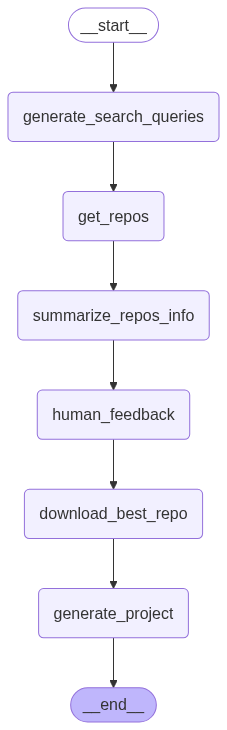

In [14]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_openai import ChatOpenAI
from dotenv import load_dotenv
from typing import List, Optional, Literal
from pydantic import Field, BaseModel
from datetime import datetime


load_dotenv()

llm = ChatOpenAI(model="gpt-4o")

#-------------------------------------------------------------
# States Definitions
#-------------------------------------------------------------

class Repository(BaseModel):
    name: str = Field(description="The name of the repository.")
    owner: str = Field(description="The owner of the repository.")
    description: str = Field(description="A brief description of the repository.")
    url: str = Field(description="The URL of the repository.")
    language: Optional[list[str]] = Field(description="The programming languages used in the repository.")
    topics: Optional[list[str]] = Field(description="A list of topics associated with the repository.")
    stars: int = Field(description="The number of stars the repository has received.")
    forks: int = Field(description="The number of forks of the repository.")
    open_issues: int = Field(description="The number of open issues in the repository.")
    license: Optional[str] = Field(description="The license under which the repository is released.")
    created_at: datetime = Field(description="The date and time when the repository was created.")
    updated_at: datetime = Field(description="The date and time when the repository was last updated.")
    download_path: Optional[str] = Field(description="The path to download the repository.")


class SupervisorState(MessagesState):
    route: Literal["project_builder", "coding_assistant"] = Field(description="The route to follow in the workflow.")


class CodingAssistantState(MessagesState):
    """Coding assistant state to help users with debugging, optimizing code ...etc."""


class ProjectBuilderState(MessagesState):
    project_description: str = Field(description="Project description provided by the supervisor.")
    tech_stack: Optional[str] = Field(description="Tech stack for the project, if applicable.")
    search_queries: List[str] = Field(description="3 search queries for github repos.")
    repos: List[Repository] = Field(description="top 3 best matching repos.")
      

#-------------------------------------------------------------
# Prompts
#-------------------------------------------------------------      

generate_search_query_prompt = """You will be given a project description by the supervisor (enhance the project description by adding more details if needed.). 

Your goal is to generate a well-structured query for use in retrieval and / or github-search related to the description.
        
First, analyze the full description.

Convert this description into a well-structured github search query that is specific, clear, and concise.

The query should be relevant to the description and should not include any personal opinions or irrelevant information."""    


search_repos_prompt = """
You are an expert in searching for GitHub repositories. Given a list of search queries, find the top 3 best matching repositories for each query. Each repository should be described with the following fields:
- name: The name of the repository
- owner: The owner of the repository
- description: A brief description of the repository
- url: The URL of the repository
- language: The primary programming language used in the repository
- topics: A list of topics associated with the repository
- stars: The number of stars the repository has received
- forks: The number of forks of the repository
- open_issues: The number of open issues in the repository
- license: The license under which the repository is released
- created_at: The date and time when the repository was created
- updated_at: The date and time when the repository was last updated
- is_private: A boolean indicating whether the repository is private or public
Return the results in a structured format as a list of dictionaries, where each dictionary represents a repository
"""


coding_assistant_prompt = """
    You are a coding assistant tasked with helping users to debbug their code and/or optimizing their code.

    if the user wants to debbug their code, you will ask them to provide the code and the error message, and give him the answer.

    If the user wants to optimize their code, you will ask them to provide the code, and give him the answer.

    If the user wants to build a project, you will ask them to provide the project description and to mention the tech stack (programming languages, tools...etc).
        - enhance the project description by adding more details if needed.
"""

supervisor_prompt = """
You are a supervisor who will guide the user through the project building process or coding assistance.
You will decide the next step based on the user input.
Decide the route based on intent:
- If the user wants to build a project, set the route to "project_builder" -> output "project_builder".
- If not, set the route to "coding_assistant" -> output
only respond with one of the following words: "project_builder" or "coding_assistant" based on the user input.
"""


#-------------------------------------------------------------
# nodes
#-------------------------------------------------------------

def supervisor(state: SupervisorState) -> SupervisorState:
    """
    Supervisor function decides the next step "project_builder" or "coding_assistane".
    """
    pass


def router(state: SupervisorState) -> Literal["project_builder", "coding_assistant"]:
    """"Router function to determine the next step based on the user input."""
    if state.route == "project_builder":
        return "project_builder"
    elif state.route == "coding_assistant":
        return "coding_assistant"


def coding_assistant(state: SupervisorState):
    """
    Coding assistant function to help users with debugging, optimizing code.
    """
    pass

def generate_search_queries(state: SupervisorState) -> ProjectBuilderState:
    """
    Function to generate search queries based on the project description.
    """
    pass

def get_repos(state: ProjectBuilderState) -> ProjectBuilderState:
    """
    Tool function to retrieve GitHub repositories based on the search queries.
    """
    pass

def summarize_repos_info(state: ProjectBuilderState) -> ProjectBuilderState:
    """
    Function to summarize the information of the retrieved repositories.
    """
    pass

def human_feedback(state: ProjectBuilderState) -> ProjectBuilderState:
    """
    Function to get human feedback on the best matching repository.
    """
    pass

def download_best_repo(state: ProjectBuilderState) -> ProjectBuilderState:
    """
    Function to download the best matching repository.
    """
    pass


def generate_project(state: ProjectBuilderState) -> ProjectBuilderState:
    """
    Function to generate a project based on the best matching repository.
    """
    pass



#-------------------------------------------------------------
# Project Builder Workflow
#-------------------------------------------------------------

project_builder_graph = StateGraph(SupervisorState)    

project_builder_graph.add_node("generate_search_queries", generate_search_queries)
project_builder_graph.add_node("get_repos", get_repos)
project_builder_graph.add_node("summarize_repos_info", summarize_repos_info)
project_builder_graph.add_node("human_feedback", human_feedback)
project_builder_graph.add_node("download_best_repo", download_best_repo)
project_builder_graph.add_node("generate_project", generate_project)

project_builder_graph.add_edge(START, "generate_search_queries")
project_builder_graph.add_edge("generate_search_queries", "get_repos")
project_builder_graph.add_edge("get_repos", "summarize_repos_info")
project_builder_graph.add_edge("summarize_repos_info", "human_feedback")
project_builder_graph.add_edge("human_feedback", "download_best_repo")
project_builder_graph.add_edge("download_best_repo", "generate_project")
project_builder_graph.add_edge("generate_project", END)

project_builder = project_builder_graph.compile()

from IPython.display import display, Image
display(Image(project_builder.get_graph().draw_mermaid_png()))


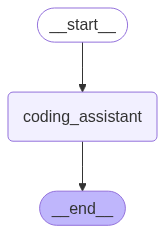

In [15]:

#-------------------------------------------------------------
# Coding Assistant Workflow
#-------------------------------------------------------------

coding_assistant_graph = StateGraph(CodingAssistantState)

coding_assistant_graph.add_node("coding_assistant", coding_assistant)

coding_assistant_graph.add_edge(START, "coding_assistant")
coding_assistant_graph.add_edge("coding_assistant", END)

coding_assistant = coding_assistant_graph.compile()
 


display(Image(coding_assistant.get_graph().draw_mermaid_png()))

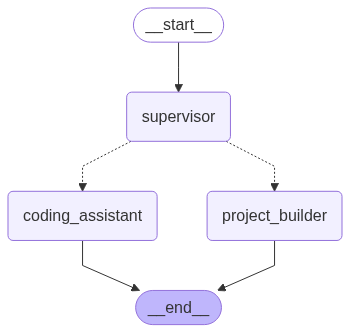

In [16]:

#-------------------------------------------------------------
# Main Workflow
#-------------------------------------------------------------


graph = StateGraph(SupervisorState)

graph.add_node("supervisor", supervisor)
graph.add_node("project_builder", project_builder_graph.compile())
graph.add_node("coding_assistant", coding_assistant_graph.compile())

graph.add_edge(START, "supervisor")
graph.add_conditional_edges("supervisor",router)
graph.add_edge("project_builder", END)
graph.add_edge("coding_assistant", END)

workflow = graph.compile()

display(Image(workflow.get_graph().draw_mermaid_png()))